# Examples of generating a request sequence
## - using the WorkloadFit class

Input data is represented by:
 * Log data for neuroscience applications (log_example.in)
     * Array of past execution times

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as st

import WorkloadFit
import OptimalSequence

In [2]:
bins=100

# Log data

If cost is needed use:
`cost_model = WorkloadFit.LogDataCost(data)`

This example computes the sequence of requests
- using the discrete data
- using both interpolation models (polynomial and distribution) to go through a continuous fit
- using distribution interpolation for the checkpoint sequence model

In [3]:
dataset = "./log_example.in"
data = np.loadtxt(dataset, delimiter=' ')
print("Total entries in the historic data: %d" %(len(data)))

Total entries in the historic data: 5276


In [4]:
wf = WorkloadFit.WorkloadFit(data, bins=bins)
discrete_sequence = wf.compute_discrete_sequence()
print("Discrete sequence: %s" %(discrete_sequence))

Discrete sequence: [(129614.0,), (148864.0,), (172825.0,)]


In [5]:
wf.set_interpolation_model([WorkloadFit.PolyInterpolation(max_order=10),
                            WorkloadFit.DistInterpolation()])
sequence = wf.compute_interpolation_sequence()
print("Best fit sequence: %s" %(sequence))

Best fit sequence: [(112777.054,), (152173.59,), (172825.0,)]


In [6]:
# compute the sequence when checkpoints are taken before the reservation end
wf.change_default_sequence_model(OptimalSequence.CheckpointSequence)
wf.set_interpolation_model([WorkloadFit.DistInterpolation()])
check_sequence = wf.compute_interpolation_sequence()
print("Best fit sequence (with checkpoints): %s" %(check_sequence))

Best fit sequence (with checkpoints): [(91172.502, 1), (10802.276, 0), (31771.4, 0), (59094.804, 0), (81652.498, 0)]


In [7]:
data = [i/3600 for i in data]
sequence = [i[0]/3600 for i in sequence]
discrete_sequence = [i[0]/3600 for i in discrete_sequence]
check_sequence = [(i[0]/3600, i[1]) for i in check_sequence]

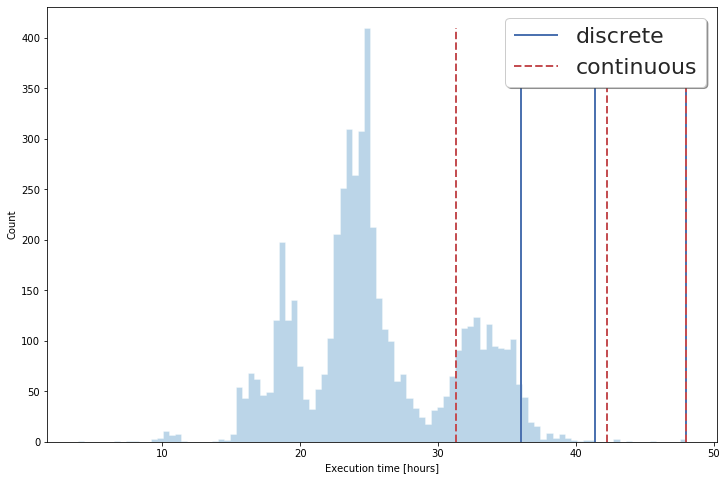

In [8]:
y, x = np.histogram(data, bins=bins)
x = (x + np.roll(x, -1))[:-1] / 2.0

fig, ax = plt.subplots(figsize=(12,8))
sns.set(font_scale=2)
sns.set_style("white")
ax.hist(data, bins=bins, histtype='stepfilled', alpha=0.3)

ax.vlines(discrete_sequence[0], min(y), max(y), colors='b', lw=2,
          linestyles='solid', label='discrete')
for i in range(1,len(discrete_sequence)):
    ax.vlines(discrete_sequence[i], min(y), max(y), colors='b', lw=2, linestyles='solid')

ax.vlines(sequence[0], min(y), max(y), colors='r', linestyles='dashed', lw=2, label='continuous')
for i in range(1,len(sequence)):
    ax.vlines(sequence[i], min(y), max(y), colors='r', linestyles='dashed', lw=2)

ax.legend(shadow=True)
ax.set_xlabel('Execution time [hours]')
ax.set_ylabel('Count')
plt.show()

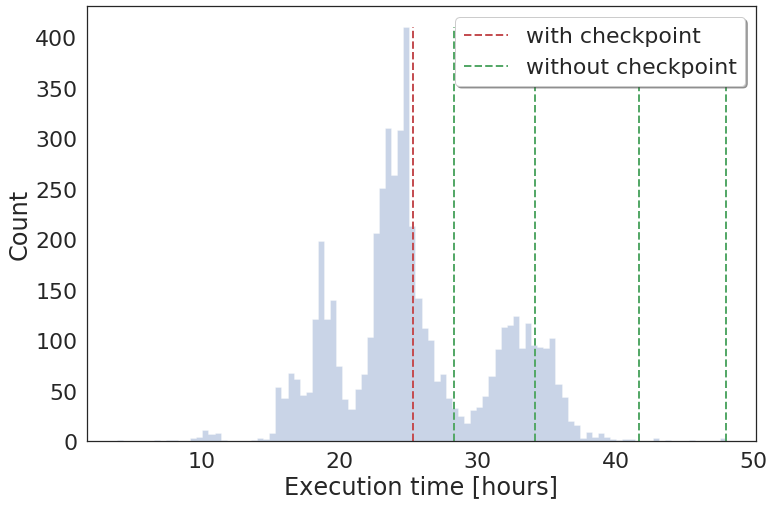

In [9]:
y, x = np.histogram(data, bins=bins)
x = (x + np.roll(x, -1))[:-1] / 2.0

fig, ax = plt.subplots(figsize=(12,8))
sns.set(font_scale=2)
sns.set_style("white")
ax.hist(data, bins=bins, histtype='stepfilled', alpha=0.3)

elapsed_time = 0
for i in range(len(check_sequence)):
    col = 'r' if check_sequence[i][1] == 1 else 'g'
    ax.vlines(check_sequence[i][0] + elapsed_time, min(y), max(y), colors=col, linestyles='dashed', lw=2)
    if check_sequence[i][1] == 1:
        elapsed_time += check_sequence[i][0]
    
ax.vlines(min(x), 0, 0, colors='r', linestyles='dashed', lw=2, label='with checkpoint')
ax.vlines(min(x), 0, 0, colors='g', linestyles='dashed', lw=2, label='without checkpoint')

ax.legend(shadow=True)
ax.set_xlabel('Execution time [hours]')
ax.set_ylabel('Count')
plt.show()

# Synthetic workloads

If cost is needed use:
`cost_model = WorkloadFit.SyntheticDataCost(data)`

This example computes the sequence of requests
- Generate the data using the normal distribution
- Same workflow as for the log dataset

## 1. Truncnorm

Parameters: $\mu$ = 8
$\sigma$ = 2

Truncated between [0, 20]

In [10]:
bins = 100
distribution = st.truncnorm
lower_limit = 0
upper_limit = 20
mu = 8
sigma = 2
upper_bound = (upper_limit - mu) / sigma
lower_bound = (lower_limit - mu) / sigma

In [11]:
data = distribution.rvs(lower_bound, upper_bound,
                        loc=mu, scale=sigma, size=100)

In [12]:
wf = WorkloadFit.WorkloadFit(data, bins=bins)
discrete_sequence = wf.compute_discrete_sequence()
print("Discrete sequence: %s" %(discrete_sequence))

Discrete sequence: [(10.68330618161044,), (12.529795417728579,)]


In [13]:
wf.set_interpolation_model([WorkloadFit.PolyInterpolation(max_order=10),
                            WorkloadFit.DistInterpolation()])
sequence = wf.compute_interpolation_sequence()
print("Best fit sequence: %s" %(sequence))

Best fit sequence: [(10.731035224915935,), (12.529795417728579,)]


In [14]:
# compute the sequence when checkpoints are taken before the reservation end
wf.change_default_sequence_model(OptimalSequence.CheckpointSequence, args=[False, 0.7, 0.7])
wf.set_interpolation_model([WorkloadFit.DistInterpolation()])
check_sequence = wf.compute_interpolation_sequence()
print("Best fit sequence (with checkpoints): %s" %(check_sequence))

Best fit sequence (with checkpoints): [(7.733101570228194, 1), (2.108891260538962, 1), (1.4886291250863262, 0), (2.687802586961422, 0)]


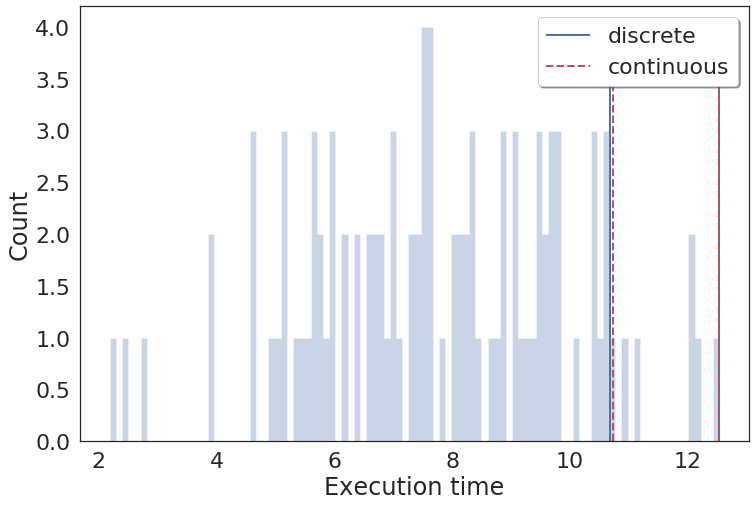

In [15]:
y, x = np.histogram(data, bins=bins) #, density=True)
x = (x + np.roll(x, -1))[:-1] / 2.0

fig, ax = plt.subplots(figsize=(12,8))
sns.set(font_scale=2)
sns.set_style("white")
ax.hist(data, bins=bins, histtype='stepfilled', alpha=0.3)

ax.vlines(discrete_sequence[0], min(y), max(y), colors='b', lw=2,
          linestyles='solid', label='discrete')
for i in range(1,len(discrete_sequence)):
    ax.vlines(discrete_sequence[i], min(y), max(y), colors='b', lw=2, linestyles='solid')

ax.vlines(sequence[0], min(y), max(y), colors='r', linestyles='dashed', lw=2, label='continuous')
for i in range(1,len(sequence)):
    ax.vlines(sequence[i], min(y), max(y), colors='r', linestyles='dashed', lw=2)

ax.legend(shadow=True)
ax.set_xlabel('Execution time')
ax.set_ylabel('Count')
plt.show()

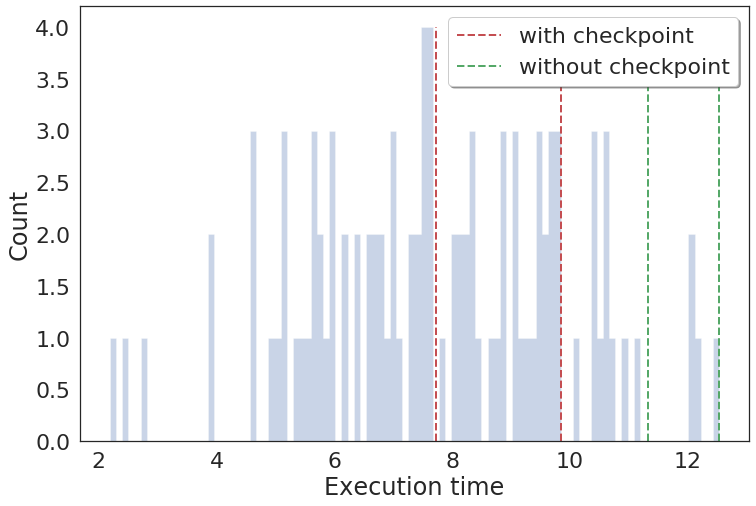

In [16]:
y, x = np.histogram(data, bins=bins)
x = (x + np.roll(x, -1))[:-1] / 2.0

fig, ax = plt.subplots(figsize=(12,8))
sns.set(font_scale=2)
sns.set_style("white")
ax.hist(data, bins=bins, histtype='stepfilled', alpha=0.3)

elapsed_time = 0
for i in range(len(check_sequence)):
    col = 'r' if check_sequence[i][1] == 1 else 'g'
    ax.vlines(check_sequence[i][0] + elapsed_time, min(y), max(y), colors=col, linestyles='dashed', lw=2)
    if check_sequence[i][1] == 1:
        elapsed_time += check_sequence[i][0]
    
ax.vlines(min(x), 0, 0, colors='r', linestyles='dashed', lw=2, label='with checkpoint')
ax.vlines(min(x), 0, 0, colors='g', linestyles='dashed', lw=2, label='without checkpoint')

ax.legend(shadow=True)
ax.set_xlabel('Execution time')
ax.set_ylabel('Count')
plt.show()

## 2. Double norm

Sum of two truncated normal distributions.

Parameters for distribution 1:
$\mu_1$ = 4 $\sigma_1$ = 2, truncated between [0.5, 4]

Parameters for distribution 2:
$\mu_2$ = 10 $\sigma_1$ = 8, truncated between [6, 20]

In [3]:
bins = 100
distribution = st.truncnorm
lower_limit = [0.5, 6]
upper_limit = [4, 20]
mu = [4, 10]
sigma = [2, 8]
upper_bound = [(upper_limit[0] - mu[0]) / sigma[0], (upper_limit[1] - mu[1]) / sigma[1]]
lower_bound = [(lower_limit[0] - mu[0]) / sigma[0], (lower_limit[1] - mu[1]) / sigma[1]]

In [4]:
data = list(distribution.rvs(lower_bound[0], upper_bound[0], 
                             loc=mu[0], scale=sigma[0], size=100)) +\
       list(distribution.rvs(lower_bound[1], upper_bound[1],
                             loc=mu[1], scale=sigma[1], size=100))

In [5]:
wf = WorkloadFit.WorkloadFit(data, bins=bins)
discrete_sequence = wf.compute_discrete_sequence()
print("Discrete sequence: %s" %(discrete_sequence))

Discrete sequence: [(3.990589015290022,), (17.257255305118242,), (19.95529677291216,)]


In [6]:
wf.set_interpolation_model([WorkloadFit.PolyInterpolation(max_order=10),
                            WorkloadFit.DistInterpolation()])
sequence = wf.compute_interpolation_sequence()
print("Best fit sequence: %s" %(sequence))

Best fit sequence: [(4.385022380764502,), (16.887836231815736,), (19.95529677291216,)]


In [7]:
# compute the sequence when checkpoints are taken before the reservation end
wf.change_default_sequence_model(OptimalSequence.CheckpointSequence, args=[False, 0.7, 0.7])
wf.set_interpolation_model([WorkloadFit.DistInterpolation()])
check_sequence = wf.compute_interpolation_sequence()
print("Best fit sequence (with checkpoints): %s" %(check_sequence))

Best fit sequence (with checkpoints): [(4.579165452985794, 1), (3.378089456650489, 1), (3.378089456650489, 1), (3.1839463844291966, 1), (2.756831625542353, 1), (2.679174396653836, 0), (3.552713678800501e-15, 0)]


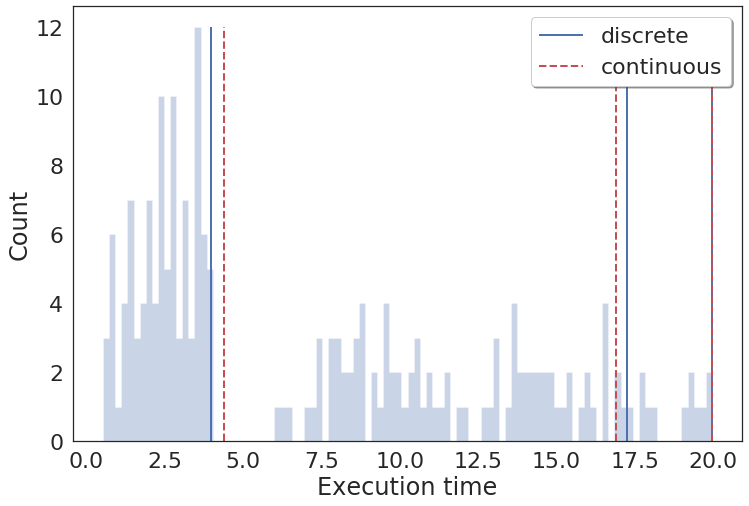

In [10]:
y, x = np.histogram(data, bins=bins) #, density=True)
x = (x + np.roll(x, -1))[:-1] / 2.0

fig, ax = plt.subplots(figsize=(12,8))
sns.set(font_scale=2)
sns.set_style("white")
ax.hist(data, bins=bins, histtype='stepfilled', alpha=0.3)

ax.vlines(discrete_sequence[0], min(y), max(y), colors='b', lw=2,
          linestyles='solid', label='discrete')
for i in range(1,len(discrete_sequence)):
    ax.vlines(discrete_sequence[i], min(y), max(y), colors='b', lw=2, linestyles='solid')

ax.vlines(sequence[0], min(y), max(y), colors='r', linestyles='dashed', lw=2, label='continuous')
for i in range(1,len(sequence)):
    ax.vlines(sequence[i], min(y), max(y), colors='r', linestyles='dashed', lw=2)

ax.legend(shadow=True)
ax.set_xlabel('Execution time')
ax.set_ylabel('Count')
plt.show()

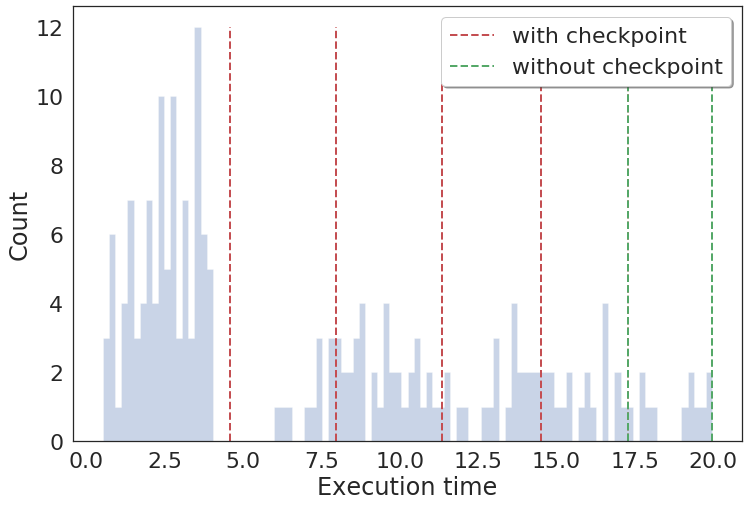

In [9]:
y, x = np.histogram(data, bins=bins)
x = (x + np.roll(x, -1))[:-1] / 2.0

fig, ax = plt.subplots(figsize=(12,8))
sns.set(font_scale=2)
sns.set_style("white")
ax.hist(data, bins=bins, histtype='stepfilled', alpha=0.3)

elapsed_time = 0
for i in range(len(check_sequence)):
    col = 'r' if check_sequence[i][1] == 1 else 'g'
    ax.vlines(check_sequence[i][0] + elapsed_time, min(y), max(y), colors=col, linestyles='dashed', lw=2)
    if check_sequence[i][1] == 1:
        elapsed_time += check_sequence[i][0]
    
ax.vlines(min(x), 0, 0, colors='r', linestyles='dashed', lw=2, label='with checkpoint')
ax.vlines(min(x), 0, 0, colors='g', linestyles='dashed', lw=2, label='without checkpoint')

ax.legend(shadow=True)
ax.set_xlabel('Execution time')
ax.set_ylabel('Count')
plt.show()